In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('fetal_health.csv')

In [3]:
df.describe()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [4]:
x = df.iloc[:, 0:21]
x.head()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,2.4,64,62,126,2,0,120,137,121,73,1
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,10.4,130,68,198,6,1,141,136,140,12,0
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,13.4,130,68,198,5,1,141,135,138,13,0
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,23.0,117,53,170,11,0,137,134,137,13,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,19.9,117,53,170,9,0,137,136,138,11,1


In [5]:
# Using mean normalization to normalize data.
col_to_norm = ['baseline_value', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability',
           'percentage_of_time_with_abnormal_long_term_variability','mean_value_of_long_term_variability',
           'histogram_width','histogram_min','histogram_max','histogram_number_of_peaks','histogram_mode',
           'histogram_mean','histogram_median','histogram_variance']
x[col_to_norm] = x[col_to_norm].apply(lambda x : (x-x.mean()) / x.std())

In [6]:
x[col_to_norm].describe()

,baseline_value,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance
count,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03
mean,1.113461e-15,-4.773019e-17,-1.146569e-15,-2.634665e-15,2.902873e-15,-1.941063e-16,-1.485694e-16,-1.162183e-16,-4.292584e-16,-3.797005e-16,-4.836207e-16,2.863811e-16,7.557454e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.774544e+00,-2.035160e+00,-1.282531e+00,-5.352354e-01,-1.454739e+00,-1.731349e+00,-1.474262e+00,-2.342007e+00,-1.379339e+00,-4.728079e+00,-3.951015e+00,-4.222855e+00,-6.490554e-01
25%,-7.421982e-01,-8.718830e-01,-7.164345e-01,-5.352354e-01,-6.374329e-01,-8.585628e-01,-8.991645e-01,-6.701559e-01,-7.012319e-01,-5.159559e-01,-6.163130e-01,-6.283659e-01,-5.800366e-01
50%,-3.087713e-02,1.169022e-01,-1.503378e-01,-5.352354e-01,-1.399422e-01,-7.562201e-02,-1.960378e-02,-1.128722e-01,-3.621782e-01,9.449668e-02,8.910477e-02,6.288210e-02,-4.074898e-01
75%,6.804440e-01,8.148682e-01,4.157589e-01,6.269213e-02,4.641536e-01,7.586591e-01,8.937861e-01,5.558682e-01,6.549828e-01,6.439040e-01,6.662648e-01,6.850053e-01,1.791695e-01
max,2.712790e+00,2.327128e+00,6.416384e+00,4.411256e+00,7.553395e+00,2.812274e+00,2.213127e+00,4.122484e+00,4.723627e+00,3.024669e+00,3.039034e+00,3.311748e+00,8.633966e+00


In [7]:
x.describe()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2.126000e+03,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2126.000000,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2126.000000
mean,1.113461e-15,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,-4.773019e-17,-1.146569e-15,-2.634665e-15,2.902873e-15,-1.941063e-16,-1.485694e-16,-1.162183e-16,-4.292584e-16,0.323612,-3.797005e-16,-4.836207e-16,2.863811e-16,7.557454e-16,0.320320
std,1.000000e+00,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.706059,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.610829
min,-2.774544e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.035160e+00,-1.282531e+00,-5.352354e-01,-1.454739e+00,-1.731349e+00,-1.474262e+00,-2.342007e+00,-1.379339e+00,0.000000,-4.728079e+00,-3.951015e+00,-4.222855e+00,-6.490554e-01,-1.000000
25%,-7.421982e-01,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,-8.718830e-01,-7.164345e-01,-5.352354e-01,-6.374329e-01,-8.585628e-01,-8.991645e-01,-6.701559e-01,-7.012319e-01,0.000000,-5.159559e-01,-6.163130e-01,-6.283659e-01,-5.800366e-01,0.000000
50%,-3.087713e-02,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,1.169022e-01,-1.503378e-01,-5.352354e-01,-1.399422e-01,-7.562201e-02,-1.960378e-02,-1.128722e-01,-3.621782e-01,0.000000,9.449668e-02,8.910477e-02,6.288210e-02,-4.074898e-01,0.000000
75%,6.804440e-01,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,8.148682e-01,4.157589e-01,6.269213e-02,4.641536e-01,7.586591e-01,8.937861e-01,5.558682e-01,6.549828e-01,0.000000,6.439040e-01,6.662648e-01,6.850053e-01,1.791695e-01,1.000000
max,2.712790e+00,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,2.327128e+00,6.416384e+00,4.411256e+00,7.553395e+00,2.812274e+00,2.213127e+00,4.122484e+00,4.723627e+00,10.000000,3.024669e+00,3.039034e+00,3.311748e+00,8.633966e+00,1.000000


In [8]:
x = x.values

In [9]:
y = df[['fetal_health']]
y

,fetal_health
0,2
1,1
2,1
3,1
4,1
...,...
2121,2
2122,2
2123,2
2124,2


In [10]:
y_dummies = pd.get_dummies(y, columns=['fetal_health'])
y = y_dummies
y=y.values

In [11]:
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.2, random_state = 42, stratify=y)

In [12]:
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size=0.5, random_state = 42, stratify=y_)

In [13]:
input_layer = layers.Input(shape=(21,))

In [14]:
lambda_L = 1e-5
hidden_layer = layers.Dense(128, kernel_initializer=keras.initializers.HeNormal() , kernel_regularizer=keras.regularizers.L1(lambda_L))(input_layer)
hidden_layer = layers.BatchNormalization()(hidden_layer)
hidden_layer = layers.Activation('relu')(hidden_layer)

hidden_layer = layers.Dense(128, kernel_initializer=keras.initializers.HeNormal() , kernel_regularizer=keras.regularizers.L1(lambda_L))(hidden_layer)
hidden_layer = layers.BatchNormalization()(hidden_layer)
hidden_layer = layers.Activation('relu')(hidden_layer)

hidden_layer = layers.Dense(128, kernel_initializer=keras.initializers.HeNormal() , kernel_regularizer=keras.regularizers.L1(lambda_L))(hidden_layer)
hidden_layer = layers.BatchNormalization()(hidden_layer)
hidden_layer = layers.Activation('relu')(hidden_layer)

In [15]:
output_layer = layers.Dense(3, activation='softmax')(hidden_layer)

In [16]:
model = keras.Model(inputs=input_layer, outputs=output_layer)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 128)               2816      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                             

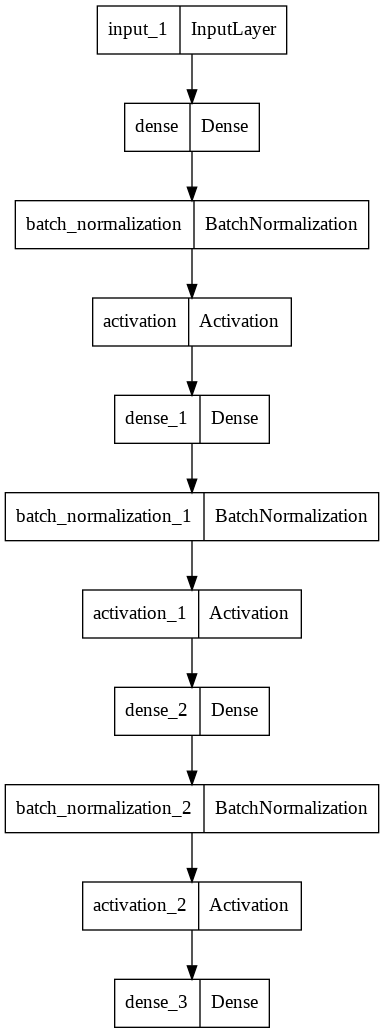

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50, restore_best_weights=True)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=7e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [21]:
history = model.fit(x=x_train, y=y_train, batch_size=1700, epochs=1500, callbacks=[earlystop], validation_data=(x_val,y_val))

Epoch 1/1500
1/1 [==============================] - 1s 1s/step - loss: 1.5873 - categorical_accuracy: 0.2206 - val_loss: 1.8003 - val_categorical_accuracy: 0.1502
Epoch 2/1500
1/1 [==============================] - 0s 62ms/step - loss: 1.4211 - categorical_accuracy: 0.2494 - val_loss: 1.7509 - val_categorical_accuracy: 0.1362
Epoch 3/1500
1/1 [==============================] - 0s 56ms/step - loss: 1.2745 - categorical_accuracy: 0.3029 - val_loss: 1.7134 - val_categorical_accuracy: 0.1362
Epoch 4/1500
1/1 [==============================] - 0s 119ms/step - loss: 1.1480 - categorical_accuracy: 0.3606 - val_loss: 1.6874 - val_categorical_accuracy: 0.1221
Epoch 5/1500
1/1 [==============================] - 0s 142ms/step - loss: 1.0410 - categorical_accuracy: 0.4665 - val_loss: 1.6712 - val_categorical_accuracy: 0.1080
Epoch 6/1500
1/1 [==============================] - 0s 84ms/step - loss: 0.9508 - categorical_accuracy: 0.5535 - val_loss: 1.6622 - val_categorical_accuracy: 0.1268
Epoch 7/15

In [22]:
model.save('model.h5')

In [23]:
model.save_weights('weight.h5')

In [24]:
y_test_predicted = model.predict(x=x_test)

In [25]:
y_pred = y_test_predicted.argmax(axis=1)

In [26]:
y_true = y_test.argmax(axis=1)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       166
           1       0.96      0.83      0.89        29
           2       0.94      0.94      0.94        18

    accuracy                           0.96       213
   macro avg       0.96      0.92      0.94       213
weighted avg       0.96      0.96      0.96       213

